In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from statsmodels.stats.contingency_tables import mcnemar
import scipy.stats as stats
from sklearn.metrics import classification_report
# from mice import MICE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
adult19_path = '/content/drive/MyDrive/NHIS-Datasets/adult19.csv'
adult20_path = '/content/drive/MyDrive/NHIS-Datasets/adult20.csv'
adult20long_path = '/content/drive/MyDrive/NHIS-Datasets/adult20long.csv'

In [ ]:
adult19 = pd.read_csv(adult19_path)
adult20 = pd.read_csv(adult20_path)
adult20long = pd.read_csv(adult20long_path)

In [ ]:
print(adult19.shape, adult20.shape, adult20long.shape)

(31997, 534) (31568, 617) (10415, 5)


Merging pre and post-COVID 19 data

In [ ]:
adult19_new = pd.merge(adult20long, adult19, left_on = 'HHX_2019', right_on = 'HHX')
adult20_new = pd.merge(adult20long,  adult20, left_on = 'HHX_2020', right_on = 'HHX')
# data = pd.merge(adult19_new, adult20, left_on = 'HHX_2020', right_on='HHX')
data = pd.merge(adult19_new, adult20_new, left_on = 'HHX_2020', right_on='HHX')
print("There are", data.shape[0],"patients,", data[data['SEX_A_x']==1].shape[0], "men and", data[data['SEX_A_x']==2].shape[0], "women")

There are 10415 patients, 4790 men and 5624 women


McNemar Test (Chi-square test doesn't work as it is a pre-post data)

In [ ]:
def mcnemar_test(pre, post):
  # delete indices with any answer other than yes/no
  indices_to_remove = []
  for i in range(pre.shape[0]):
    if (pre[i] != 1 and pre[i] != 2 ) or (post[i] != 1 and post[i] != 2):
      indices_to_remove.append(i)
  pre = np.delete(np.array(pre), indices_to_remove)
  post = np.delete(np.array(post), indices_to_remove)

  # make contingency table
  table = [[0, 0], [0, 0]]
  for i in range(pre.shape[0]):
      if pre[i] == 1 and post[i] == 1:
        table[0][0] += 1
      if pre[i] == 1 and post[i] == 2:
        table[0][1] += 1
      if pre[i] == 2 and post[i] == 1:
        table[1][0] += 1
      if pre[i] == 2 and post[i] == 2:
        table[1][1] += 1
  
  result = mcnemar(table, exact=True, correction=True)
  # summarize the finding
  print('statistic=%.3f, p-value=%.10f' % (result.statistic, result.pvalue))
  # interpret the p-value
  alpha = 0.05
  if result.pvalue > alpha:
    print('Same proportions of errors (fail to reject H0)')
  else:
    print('Different proportions of errors (reject H0)')


McNemar Test for 
1) Depression

In [ ]:
depression_pre = data['DEPEV_A_x']
depression_post = data['DEPEV_A_y']
mcnemar_test(depression_pre, depression_post)

statistic=465.000, p-value=0.0152556399
Different proportions of errors (reject H0)


McNemar Test for 
2) Anxiety

In [ ]:
anxiety_pre = data['ANXEV_A_x']
anxiety_post = data['ANXEV_A_y']
mcnemar_test(anxiety_pre, anxiety_post)

statistic=385.000, p-value=0.0000000068
Different proportions of errors (reject H0)


McNemar Test for 
3) Depression Medication

In [ ]:
depmed_pre = data['DEPMED_A_x']
depmed_post = data['DEPMED_A_y']
mcnemar_test(depmed_pre, depmed_post)

statistic=295.000, p-value=0.0742812347
Same proportions of errors (fail to reject H0)


McNemar Test for 
4) Anxiety Medication

In [ ]:
anxmed_pre = data['ANXMED_A_x']
anxmed_post = data['ANXMED_A_y']
mcnemar_test(anxmed_pre, anxmed_post)

statistic=415.000, p-value=0.0350559292
Different proportions of errors (reject H0)


Wilcoxon Signed-Rank Test for severity of depressive symptoms

In [ ]:
def wilcoxon_test(pre, post):
  indices_to_remove = []
  for i in range(pre.shape[0]):
    if (pre[i] >=7 or post[i] >= 7 ):
      indices_to_remove.append(i)
  pre = np.delete(np.array(pre), indices_to_remove)
  post = np.delete(np.array(post), indices_to_remove)
  result = stats.wilcoxon(pre, post, alternative='greater')
  print('statistic=%.3f, p-value=%.10f' % (result.statistic, result.pvalue))
  # interpret the p-value
  alpha = 0.05
  if result.pvalue > alpha:
    print('Sample distributions are equal (fail to reject H0)')
  else:
    print('Sample distributions are not equal(reject H0)')



*   H0: Depression frequency remains same
*   Ha: Depression frequency 2019 < Depression frequency 2020


In [ ]:
depressive_frequency_pre = data['DEPFREQ_A_x']
depressive_frequency_post = data['DEPFREQ_A_y']
wilcoxon_test(depressive_frequency_pre, depressive_frequency_post)

statistic=3814360.000, p-value=0.0000090054
Sample distributions are not equal(reject H0)


In [ ]:
anxiety_frequency_pre = data['ANXFREQ_A_x']
anxiety_frequency_post = data['ANXFREQ_A_y']
wilcoxon_test(anxiety_frequency_pre, anxiety_frequency_post)

statistic=7921404.000, p-value=0.0000172204
Sample distributions are not equal(reject H0)


(IGNORE after this) Visualization, PCA Cluster Analysis. For EDA of within year data and Bayesian network causal analysis, refer 2019_... and 2020_... notebooks

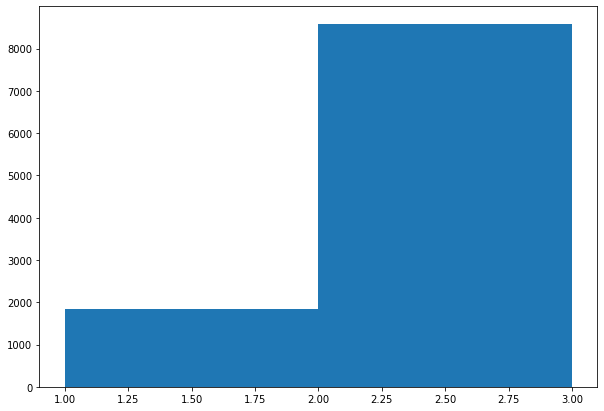

Mean pre covid: 1.828900624099856


In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(pre.values, bins = [1,2,3])
 
# Show plot
plt.show()
print("Mean pre covid:" , sum(pre.values)/len(pre.values))

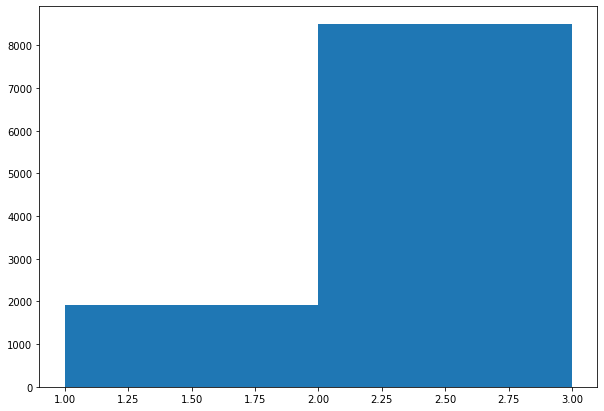

Mean post covid: 1.8247719635141624


In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(post.values, bins = [1,2,3])
 
# Show plot
plt.show()
print("Mean post covid:" , sum(post.values)/len(post.values))

In [ ]:
data = adult20_new

Find % of null values and drop columns with >70% null values

In [ ]:
null_columns = data.columns[data.isna().any()].tolist()
null_data = (100 * data[null_columns].isna().sum())/data.shape[0]
print(null_data.head())
print("Number of columns with null values =" , null_data.shape[0])

RJWKCLSOFT_A    95.976956
RJWCLSNOSD_A    97.090735
RJWRKCLSSD_A    97.090735
RECJOBSD_A      93.038886
SDMSRSOFT_A     98.415747
dtype: float64
Number of columns with null values = 406


Number of features after dropping columns with more than 90% null values

In [ ]:
threshold = 0.1 * data.shape[0]
data = data.dropna( axis = 1, thresh = threshold)
print(data.shape[1])

422


Dropping rows with >90% null values

In [ ]:
'''print("Before removing rows =", data.shape[0])
data = data[(100 * data.isnull().sum(axis=1))/data.shape[1] < 50]
print("After removing rows =",data.shape[0])

Before removing rows = 10415
After removing rows = 10415


In [ ]:
data = data.drop(columns = ['RECTYPE_x', 'RECTYPE'])
data.shape

KeyError: ignored

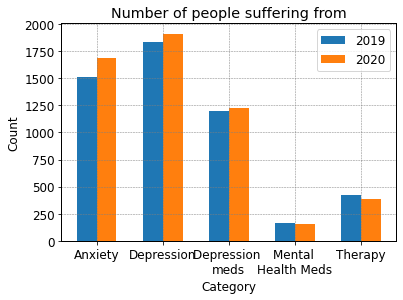

In [ ]:
index = np.arange(5)
bar_width = 0.30

count_anxiety2019 = data[data.ANXEV_A_x == 1].shape[0]
count_anxiety2020 = data[data.ANXEV_A_y == 1].shape[0]
count_depression2019 = data[data.DEPEV_A_x == 1].shape[0]
count_depression2020 = data[data.DEPEV_A_y == 1].shape[0]
count_depmed2019 = data[data.DEPMED_A_x == 1].shape[0]
count_depmed2020 = data[data.DEPMED_A_y == 1].shape[0]
count_mentmed2019 = data[data.MHRX_A_x == 1].shape[0]
count_mentmed2020 = data[data.MHRX_A_y == 1].shape[0]
count_counselling2019 = data[data.MHTHND_A_x == 1].shape[0]
count_counselling2020 = data[data.MHTHND_A_y == 1].shape[0]


fig, ax = plt.subplots()
summer = ax.bar(index, [count_anxiety2019, count_depression2019, count_depmed2019, count_mentmed2019, count_counselling2019], bar_width,
                label="2019")

winter = ax.bar(index+bar_width, [count_anxiety2020, count_depression2020, count_depmed2020, count_mentmed2020, count_counselling2020],
                 bar_width, label="2020")

ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_title('Number of people suffering from')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(["Anxiety", "Depression", "Depression \nmeds", "Mental \nHealth Meds", "Therapy"])
ax.legend()

plt.show()

In [ ]:
per = data.loc[(data['DEPFREQ_A_x'] > data['DEPFREQ_A_y']) & (data['DEPFREQ_A_x'] != 7) & (data['DEPFREQ_A_x'] != 8) & (data['DEPFREQ_A_x'] != 9) & (data['DEPFREQ_A_y'] != 7) & (data['DEPFREQ_A_y'] != 8) & (data['DEPFREQ_A_y'] != 9)].shape[0]/data.shape[0] * 100
print("For %.2f %% of people, Depressive episodes increased" %per)
per = data.loc[(data['DEPFREQ_A_x'] < data['DEPFREQ_A_y']) & (data['DEPFREQ_A_x'] != 7) & (data['DEPFREQ_A_x'] != 8) & (data['DEPFREQ_A_x'] != 9) & (data['DEPFREQ_A_y'] != 7) & (data['DEPFREQ_A_y'] != 8) & (data['DEPFREQ_A_y'] != 9)].shape[0]/data.shape[0] * 100
print("For %.2f %% of people, Depressive episodes decreased" %per)
per = data.loc[(data['DEPFREQ_A_x'] == data['DEPFREQ_A_y']) & (data['DEPFREQ_A_x'] != 7) & (data['DEPFREQ_A_x'] != 8) & (data['DEPFREQ_A_x'] != 9) & (data['DEPFREQ_A_y'] != 7) & (data['DEPFREQ_A_y'] != 8) & (data['DEPFREQ_A_y'] != 9)].shape[0]/data.shape[0] * 100
print("For %.2f %% of people, Depressive episodes continued with same frequency" %per)



For 19.12 % of people, Depressive episodes increased
For 17.06 % of people, Depressive episodes decreased
For 62.13 % of people, Depressive episodes continued with same frequency


In [ ]:
cormat = data.corr()
cormat = round(cormat,2)

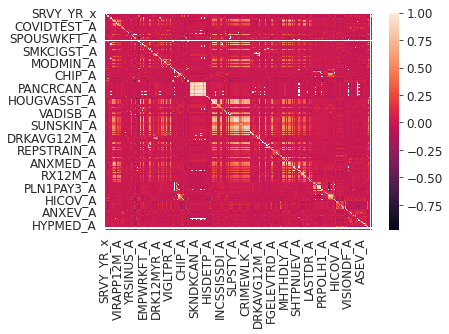

In [ ]:
sns.heatmap(cormat);

In [ ]:
data.dtypes

SRVY_YR_x       int64
RECTYPE_x       int64
WTSA_L        float64
HHX_2020       object
HHX_2019       object
               ...   
INTV_MON        int64
RECTYPE_y       int64
WTFA_A        float64
HHX            object
POVRATTC_A    float64
Length: 422, dtype: object

Preprocessing for PCA:

1.   Drop columns of object datatype as it will not be accepted in PCA (Like the unique house ID details)
2.  Imputation using mode values
3. Standard Scaler






In [ ]:
data = data.select_dtypes(exclude=['object'])
print(data.shape)

(10415, 419)


In [ ]:
for col in data.columns:
  data[col] = data[col].fillna(data[col].mode()[0])
print("Number of null values after imputation=" ,data.isna().sum().sum())

<ipython-input-140-d6b81b2fe2e9>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Number of null values after imputation= 0


In [ ]:
ss=StandardScaler()
ss.fit(data)
scaled_data=ss.transform(data)
print(scaled_data.shape)

(10415, 419)


In [ ]:
no_of_features = data.shape[1]
pca = PCA(n_components=no_of_features)
pca.fit_transform(scaled_data)

print(pca.explained_variance_[:5])
print(pca.explained_variance_ratio_[:5])
print(pca.explained_variance_ratio_.cumsum()[:5])

[50.17128507 22.76242975 15.16247918 11.54459783  9.82355467]
[0.12146845 0.05510955 0.0367095  0.02795034 0.02378356]
[0.12146845 0.176578   0.21328749 0.24123783 0.2650214 ]


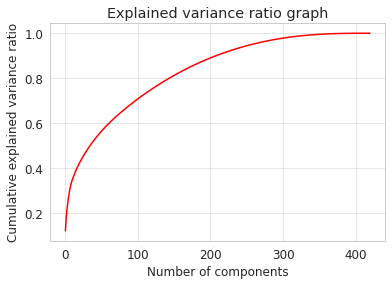

In [ ]:
x = np.arange(1, no_of_features +1)
y = pca.explained_variance_ratio_.cumsum()

plt.title("Explained variance ratio graph")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance ratio")

plt.plot(x, y, color ="red")
plt.show()

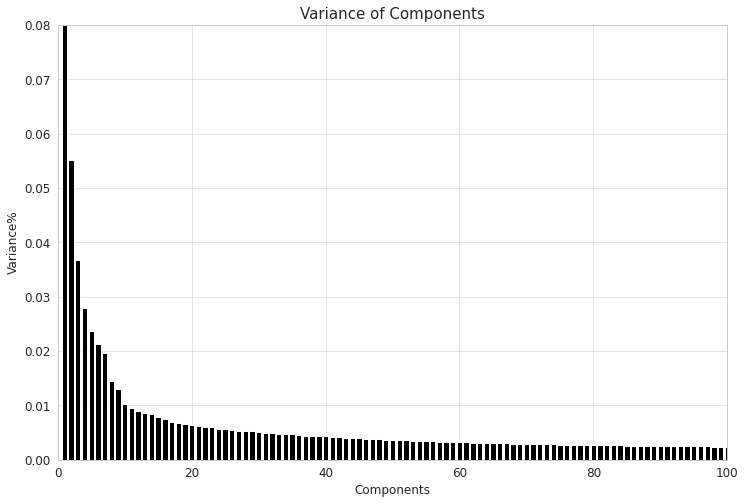

In [ ]:
plt.figure(figsize=(12,8))
plt.bar(x=list(range(1,no_of_features+1)), height=pca.explained_variance_ratio_,color='black')
plt.xlabel('Components',fontsize=12)
plt.ylim(0,0.08)
plt.xlim(0,100)
plt.ylabel('Variance%',fontsize=12)
plt.title('Variance of Components',fontsize=15)
plt.show()

Choosing number of components as 3 because there is not much change after that

In [ ]:
no_of_features = data.shape[1]
pca = PCA(n_components=3)

model = pca.fit(scaled_data)
X_pca = model.transform(scaled_data)
#X_pca = pca.fit_transform(scaled_data)

print(pca.explained_variance_[:5])
print(pca.explained_variance_ratio_[:5])
print(pca.explained_variance_ratio_.cumsum()[:5])

[50.17128507 22.76242975 15.16247918]
[0.12146845 0.05510955 0.0367095 ]
[0.12146845 0.176578   0.21328749]


In [ ]:
fig=px.scatter_3d(x=X_pca[:,0],y=X_pca[:,1],z=X_pca[:,2])
fig.update_layout(
    title={
        'text': 'First vs. Second vs. Third Principal Components',
        'y':0.92,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [ ]:

n_pcs= 3

most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = data.columns
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
df = pd.DataFrame(dic.items())
print(df)

     0            1
0  PC0  NOWWGTPRG_A
1  PC1   LARYNCAN_A
2  PC2   MEDICARE_A


In [ ]:
X=X_pca
inertia=[]
for n in range (1,11):
    model=KMeans( n_clusters=n, init='k-means++', n_init=10, max_iter=300, tol=0.0001, random_state=111,algorithm='elkan')
    model.fit(X)
    inertia.append(model.inertia_)
print(inertia)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:965: RuntimeWarning:

algorithm='elkan' doesn't make sense for a single cluster. Using 'full' instead.



[917433.7643440682, 458175.5516181419, 225361.16325150908, 120633.11360473753, 84706.22825964552, 62592.72694298523, 52489.16200539982, 43354.686390005314, 38581.781292841966, 33999.35738862553]


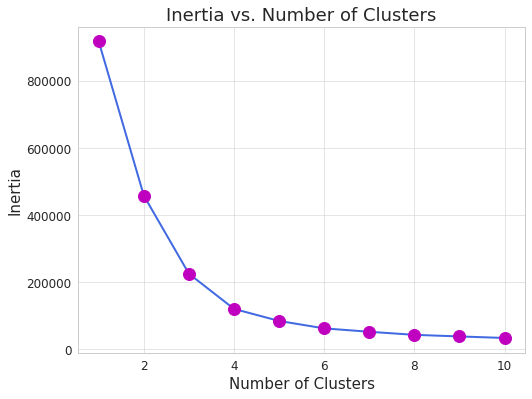

In [ ]:
plt.figure(figsize=(8,6))
sns.set_style('whitegrid')
plt.plot(list(range(1,11)), inertia, linewidth=2, markersize=12, color='royalblue', marker='o',markerfacecolor='m', markeredgecolor='m')
plt.xlabel('Number of Clusters',fontsize=15)
plt.ylabel('Inertia',fontsize=15)
plt.title('Inertia vs. Number of Clusters',fontsize=18)
plt.show()

In [ ]:
model=KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, tol=0.0001, random_state=111,algorithm='elkan')
model.fit(X)
labels=model.labels_
centers=model.cluster_centers_

In [ ]:
fig=px.scatter_3d(data_frame=df,x=X_pca[:,0],y=X_pca[:,1],z=X_pca[:,2], color=labels, color_continuous_scale='emrld')

fig.update_layout(
    title={
        'text': 'Clustering the Principal Components',
        'y':0.92,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()